# Calculate and plot protein tilts

This Jupyter Notebook contains all of the code used to calculate the transmembrane orientations of membrane proteins seen in the main text and SI of the JCTC paper. There are a few requirements for this script including MDAnalysis and matplotlib - other requirements should come with these two packages.

## Calculating the protein tilt
The tilt was determined by calculating the prinicpal axes of the transmembrane region of each protein backbone and then getting the angle between the most veritcal prinicipal axis and the z axis. During the calculation if the protein tilt for a single system if the principal axis used for protein tilt calculation changed an error was raised. This is because such an occurance likley indicates that either the protein tilt is close to 90 degrees or more likley that in that case the prinipal axis is a poor representation of the protein tilt. 

In [1]:
from __future__ import print_function, division
import numpy as np
import MDAnalysis as mda
import pandas as pd
import get_leaflets


In [2]:
def calc_tilt(barrel, structure, trajectory, cutoff=30, start=0, stop=-1, step=10):
    u = mda.Universe(structure, trajectory)
    if stop == -1:
        stop = u.trajectory.n_frames
    start, stop, step = u.trajectory.check_slice_indices(
        start, stop, step)
    
    num_steps = len(range(start, stop, step))
    if num_steps == 0:
        raise ValueError("Selected time interval does not exist in the trajectory")
    
    protein_trns_memb = u.atoms[barrel.indices]
    z_axis = np.array([0., 0., 1.])
    z_axis_norm = np.linalg.norm(z_axis)
    tilt_angles = []
    time_series = []
    axes_tseries = []
    compare_axes = None
    for frame in u.trajectory[start:stop:step]:
        time_series.append(frame.time / 1000)
        axes = protein_trns_memb.principal_axes()
        
        axes_diff = [1 - abs(x) for x in axes[:, 2]]
        trans_membrane_axis_order = np.argmin(axes_diff)

        axes_tseries.append(trans_membrane_axis_order)
        if compare_axes is None:
            compare_axes = trans_membrane_axis_order
        else:
            if trans_membrane_axis_order != compare_axes:
                raise Exception("Error: transmembrane axes changes")
            
        
        protein_axis = axes[trans_membrane_axis_order]
        tilt = np.arccos( np.dot(z_axis, protein_axis) / (z_axis_norm * np.linalg.norm(protein_axis) ) )
        tilt *= 0.5 * 360. / np.pi
        if tilt > 90:
            tilt = 180 - tilt
        tilt_angles.append(tilt)
    tilt_angles = np.array(tilt_angles)
    time_series = np.array(time_series)
    return time_series, tilt_angles, np.array(axes_tseries)

def block_average(x, y, window=50):
    x_df = pd.DataFrame(x)
    y_df = pd.DataFrame(y)
    x_av = x_df.rolling(window=window).mean().values[::window][1:]
    y_av = y_df.rolling(window=window).mean().values[::window][1:]
    y_err = y_df.rolling(window=window).std().values[::window][1:]
    return x_av, y_av, y_err

Here we load the structure of each protein and select the transmembrane region to be used for angle calculations. Later the indices of each 'barrel' object are used to select the same protein in other membrane systems. Thus it is important that the protein is the first molecule in each gro file and that the structure files are indexed in the same manner.

In each case the transmembrane region was selected as follows:
 - First we only consider beads in the backbone of each protein
 - Now by eye the tranmembrane region of each protein was selected
 - Using a vmd package 'Orient' that can be found [here](http://www.ks.uiuc.edu/Research/vmd/script_library/scripts/orient/) the principal axes of a subsection of a system can be drawn in vmd for a single frame. The prinicpal axes were drawn on every frame using the script linked [here](https://gist.github.com/melvrl13/7d051fab1ec1fc2fe54e) (note that this script requires the Orient package).
 - By visualising the prinicapl axes of each protein we refined the transmembrane selection give prinipal axes that best spanned the pore axis. 
 
In case of OmpF the above procedure was not done as all of the trialed selections gave a poor representation of the pore axis in the transmembrane region. Instead given the symmetric nature of OmpF (especially with the haromic retrictions present in a coarse grained model) the entire protein backbone was used to calculate the principal axes of OmpF. So the Tilt of OmpF is not an averaged tilt of each monomer barrel, but instead the tilt of the entire trimer.


In [3]:
wdir = "/media/jon/PhDparty/membrane_proteins/"
path = wdir+ "OMPA/RE/"
path2 = wdir+ "OMPA/RE/toppar/"
filenames = [path2 + name for name in ["martini_v2.0_lipids_all_201506.itp", "FHUA_F.itp"]]

u = mda.Universe(path+"production_whole.gro")
protein = u.select_atoms("name BB")
barrelOMPA = protein.select_atoms("not resid 1:4 146:158 17:33 60:73 103:118")

/home/jon/anaconda2/lib/python2.7/site-packages/MDAnalysis/topology/guessers.py:72: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/jon/anaconda2/lib/python2.7/site-packages/MDAnalysis/topology/guessers.py:72: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [4]:
wdir = "/media/jon/PhDparty/membrane_proteins/"
path = wdir+ "OMPX/RE/"
path2 = wdir+ "OMPX/RE/toppar/"
filenames = [path2 + name for name in ["martini_v2.0_lipids_all_201506.itp", "FHUA_F.itp"]]

u = mda.Universe(path+"production_whole.gro")
protein = u.select_atoms("name BB")
barrelOMPX = protein.select_atoms("not resid 48:61 88:105 131 137 12 21")

In [5]:
wdir = "/media/jon/PhDparty/membrane_proteins/"
path = wdir+ "ESTA/RE/"
path2 = wdir+ "ESTA/RE/toppar/"
filenames = [path2 + name for name in ["martini_v2.0_lipids_all_201506.itp", "FHUA_F.itp"]]

u = mda.Universe(path+"production_whole.gro")
protein = u.select_atoms("name BB")
barrelESTA = protein.select_atoms("not resid 1:342 441:462 401:411 360:370 553:575 499:518")

In [6]:
wdir = "/media/jon/PhDparty/membrane_proteins/"
path = wdir+ "BTUB/RE/"
path2 = wdir+ "BTUB/RE/toppar/"
filenames = [path2 + name for name in ["martini_v2.0_lipids_all_201506.itp", "FHUA_F.itp"]]

u = mda.Universe(path+"production_whole.gro")
protein = u.select_atoms("name BB")
barrelBTUB = protein.select_atoms("not resid 1:137 485:500 523:545 438:461 392:416 318:338 360:369 270:296 223:247 175:199 568:584")

In [7]:
wdir = "/media/jon/PhDparty/membrane_proteins/"
path = wdir+ "FHUA/OANT/"
path2 = wdir+ "FHUA/OANT/toppar/"
filenames = [path2 + name for name in ["martini_v2.0_lipids_all_201506.itp", "FHUA_F.itp"]]

u = mda.Universe(path+"production_whole.gro")
protein = u.select_atoms("name BB")
barrelFHUA = protein.select_atoms("not resid 1:160 308:350 386:438 243:274 558:576 515:524 605:618 470:482 653:664 700:712 205:207 365:370 185:189 633:639 678:682")

In [8]:
wdir = "/media/jon/PhDparty/membrane_proteins/"
path = wdir+ "OMPF/RE/"
path2 = wdir+ "OMPF/RE/toppar/"
filenames = [path2 + name for name in ["martini_v2.0_lipids_all_201506.itp", "FHUA_F.itp"]]

u = mda.Universe(path+"production_whole.gro")
protein = u.select_atoms("name BB")
barrelOMPF1 = protein.select_atoms("not resid 100:135 23:36 315:331 277:294 233:256 193:213 159:173 69:80 2:10 49:55")
barrelOMPF2 = u.atoms[barrelOMPF1.indices + 340]
barrelOMPF3 = u.atoms[barrelOMPF1.indices + 340*2]
barrelOMPF = protein

In [9]:
barrels = [barrelOMPA, barrelOMPX, barrelBTUB, barrelFHUA, barrelESTA, barrelOMPF]

Now we calculate the tilt for each system and subsequently save these results to a pickle file. The trajectories required to run this part of the script can be found on the [osf database](https://osf.io/p3gsq/). Otherwise a pickle file of the results of each set of calculations has been provided.

In [13]:
wdir = "/media/jon/PhDparty/membrane_proteins/"
protein = ["OMPA", "OMPX", "BTUB", "FHUA", "ESTA", "OMPF"] #names of protein directories

LPS_type = ["RE", "RA", "RA_r", "RE_r", "OANT", "OANT_r", "OANT_PE", "OANT_PE_r"] #names of membrane directories 
time_dict = {}
tilt_dict = {}
axes_dict = {} #stores info on the prinicpal axes used for each calculation for each frame
for i, p in enumerate(protein):
    path2 = wdir + "{0}/OANT/".format(p)
    for lps in LPS_type:
        membrane_protein = "{0}/{1}/".format(p, lps)
        path = wdir + membrane_protein

        try:

            time, tilt, axes = calc_tilt(barrels[i], path + "production_whole.gro", 
                                                                   path+"production_whole.xtc", step=1)
            print(p, lps)
            time_dict[p][lps] = time
            tilt_dict[p][lps] = tilt
            axes_dict[p][lps] = axes
        except KeyError:
            time_dict[p] = {}
            tilt_dict[p] = {}
            axes_dict[p] = {}
            time_dict[p][lps] = time
            tilt_dict[p][lps] = tilt
            axes_dict[p][lps] = axes
    

OMPA RE
OMPA RA
OMPA RA_r
OMPA RE_r
OMPA OANT
OMPA OANT_r
OMPA OANT_PE
OMPA OANT_PE_r
OMPX RE
OMPX RA
OMPX RA_r
OMPX RE_r
OMPX OANT
OMPX OANT_r
OMPX OANT_PE
OMPX OANT_PE_r
BTUB RE
BTUB RA
BTUB RA_r
BTUB RE_r
BTUB OANT
BTUB OANT_r
BTUB OANT_PE
BTUB OANT_PE_r
FHUA RE
FHUA RA
FHUA RA_r
FHUA RE_r
FHUA OANT
FHUA OANT_r
FHUA OANT_PE
FHUA OANT_PE_r
ESTA RE
ESTA RA
ESTA RA_r
ESTA RE_r
ESTA OANT
ESTA OANT_r
ESTA OANT_PE
ESTA OANT_PE_r
OMPF RE
OMPF RA
OMPF RA_r
OMPF RE_r
OMPF OANT
OMPF OANT_r
OMPF OANT_PE
OMPF OANT_PE_r


In [13]:
import pickle as p
import json as js

In [20]:
#save results to pickle file#
all_data = {}
all_data["time"] = time_dict
all_data["tilt"] = tilt_dict
all_data["princ_axes"] = axes_dict
with open('protein_tilt_OM.p', 'w') as f:
    p.dump(all_data, f)

In [16]:
#load results from pickle file#
all_data = p.load(open("protein_tilt_OM.p", "rb"))
time_dict = all_data["time"]
tilt_dict = all_data["tilt"]

In [14]:
#tilt calculations for DPPC membrane systems
barrels = [barrelOMPA, barrelOMPX]
protein = ["OMPA", "OMPX"]
LPS_type = ["DPPC", "DPPC_r"]
time_dictsym = {}
tilt_dictsym = {}
axes_dictsym = {}
for i, p in enumerate(protein):
    path2 = wdir + "{0}/OANT/".format(p)
    for lps in LPS_type:
        membrane_protein = "{0}/{1}/".format(p, lps)
        path = wdir + membrane_protein

        try:

            time, tilt, axes = calc_tilt(barrels[i], path + "production_whole.gro", 
                                                                   path+"production_whole.xtc", step=1)
            print(p, lps)
            time_dictsym[p][lps] = time
            tilt_dictsym[p][lps] = tilt
            axes_dictsym[p][lps] = axes
        except KeyError:
            time_dictsym[p] = {}
            tilt_dictsym[p] = {}
            axes_dictsym[p] = {}
            time_dictsym[p][lps] = time
            tilt_dictsym[p][lps] = tilt
            axes_dictsym[p][lps] = axes

OMPA DPPC
OMPA DPPC_r
OMPX DPPC
OMPX DPPC_r


## Plotting Figures seen in paper

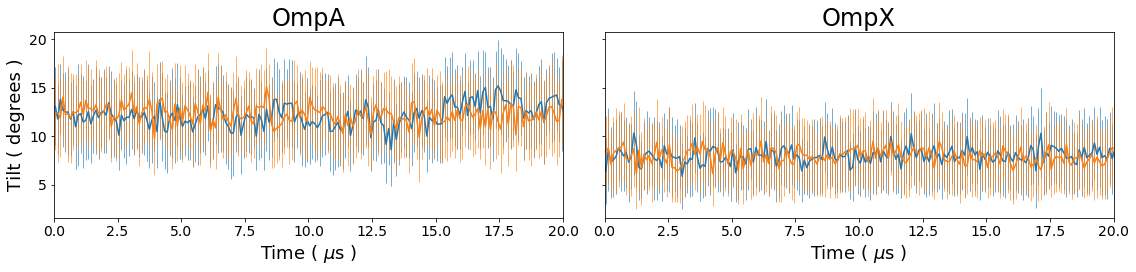

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({'font.size': 14})

proteins = ["OMPA", "OMPX"]
eline=0.6
colours = ["r", "b", "g"]
names = ["OmpA", "OmpX"]
plot_axes = []
lps_w = "DPPC"
fig, axarray = plt.subplots(1, 2, figsize=(16, 4), sharex=True, sharey=True)

for prot, ax in zip(proteins, axarray):

    for lps in tilt_dictsym[prot]:
        if lps == lps_w or lps==lps_w +"_r":
            times = time_dictsym[prot][lps] / 1000.
            tilts = tilt_dictsym[prot][lps]
            times, tilts, errors = block_average(times, tilts, window=100)
            plot = ax.errorbar(times, tilts, yerr=errors, elinewidth=eline)

#Set axes titles for figure

for i, name in enumerate(names):
    axarray[i].set_title(names[i], fontsize=24)

size = 18
axarray[0].set_ylabel(r'Tilt ( degrees )', fontsize=size)
axarray[0].set_xlabel(r'Time ( $\mu$s )', fontsize=size)
axarray[1].set_xlabel(r'Time ( $\mu$s )', fontsize=size)
axarray[0].set_xlim(0, 20)

fig.tight_layout()
fig.savefig("PL_tilts.eps", dpi=300)

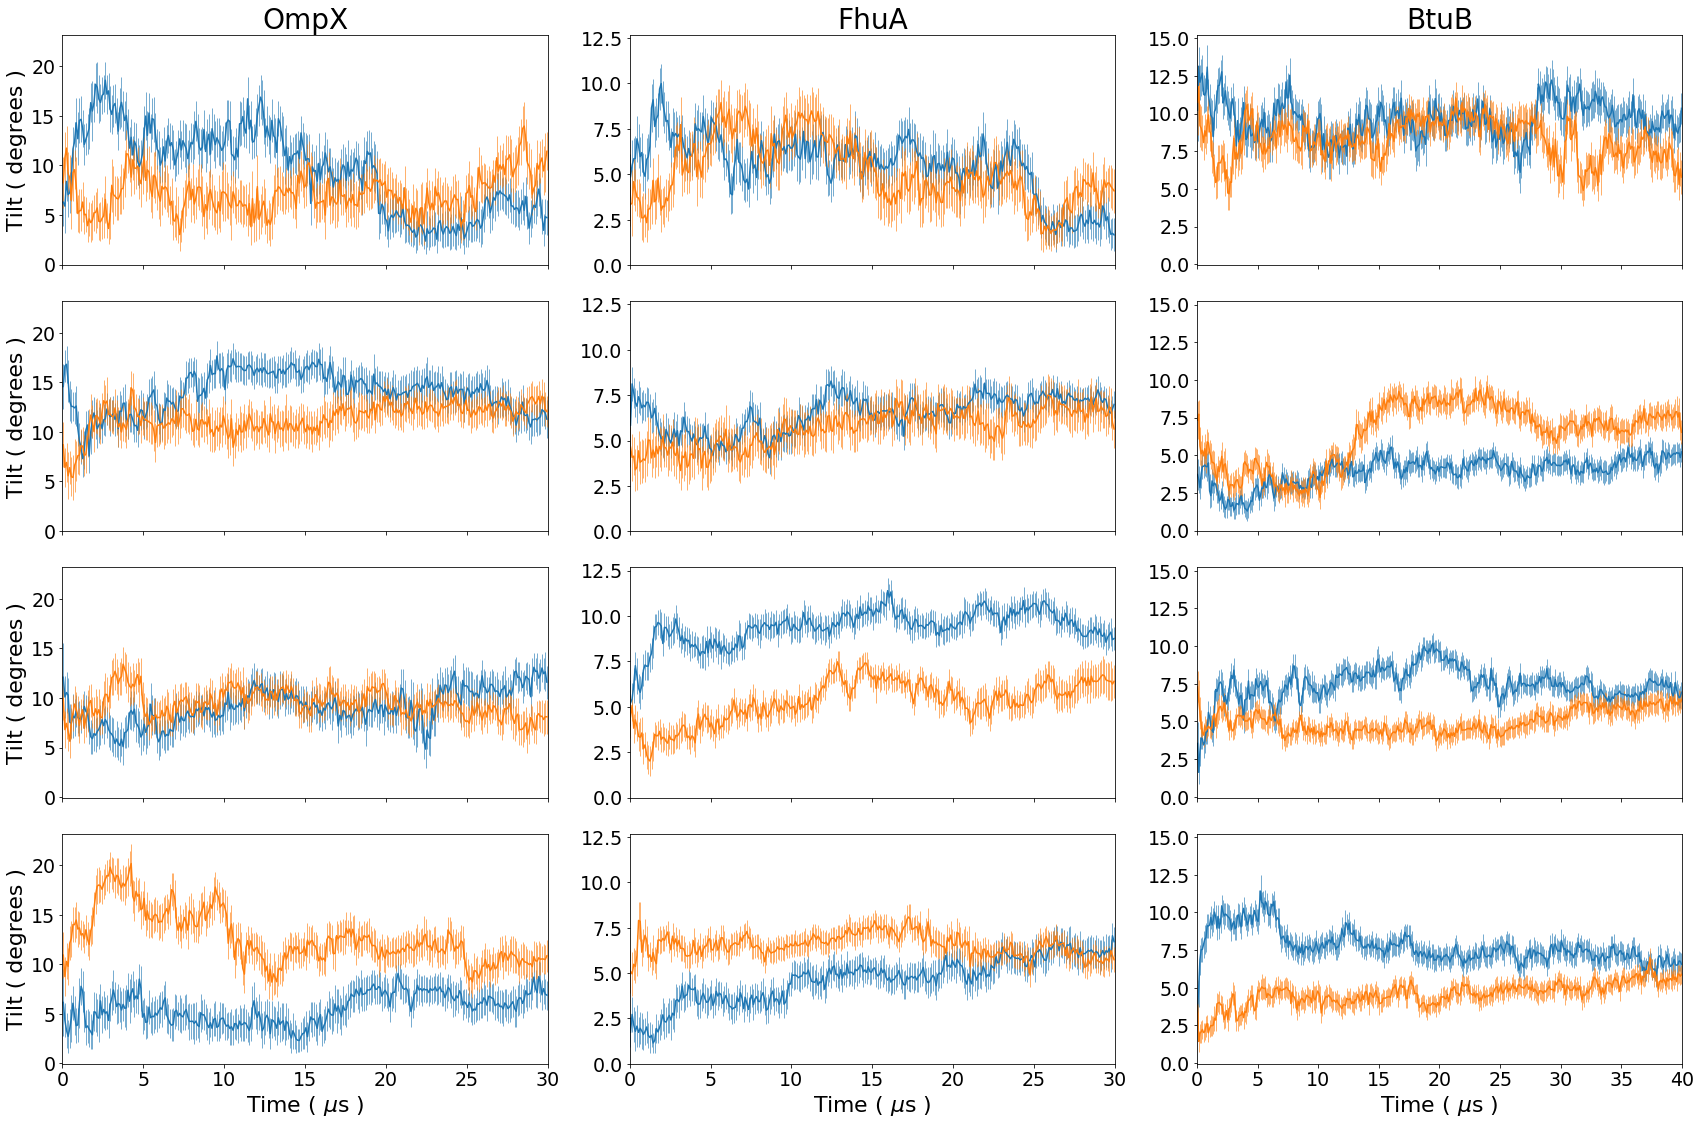

In [18]:
#Plots Figure S1A
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update({'font.size': 19})
proteins = ["OMPX", "FHUA", "BTUB"]
#lps_w = "RA"
eline=0.6
colours = ["r", "b", "g"]
names = ["OmpX", "FhuA", "BtuB"]
plot_axes = []
lps_all = ["RE", "RA", "OANT", "OANT_PE"]
fig, axarray = plt.subplots(4, 3, figsize=(24, 16), sharex="col", sharey="col")
#print(axarray)
axarray = axarray.T
for prot, paxarray in zip(proteins, axarray):
    for lps_w, ax in zip(lps_all, paxarray):

        for lps in tilt_dict[prot]:
            if lps == lps_w or lps==lps_w +"_r":
                times = time_dict[prot][lps] / 1000.
                tilts = tilt_dict[prot][lps]
                times, tilts, errors = block_average(times, tilts, window=100)
                plot = ax.errorbar(times, tilts, yerr=errors, elinewidth=eline)
    

for i, name in enumerate(names):
    axarray[i, 0].set_title(names[i], fontsize=28)
    
size = 22
axarray[0, 2].set_ylabel(r'Tilt ( degrees )', fontsize=size)
axarray[0, 1].set_ylabel(r'Tilt ( degrees )', fontsize=size)
axarray[0, 0].set_ylabel(r'Tilt ( degrees )', fontsize=size)
axarray[0, 3].set_ylabel(r'Tilt ( degrees )', fontsize=size)
axarray[0, 3].set_xlabel(r'Time ( $\mu$s )', fontsize=size)
axarray[1, 3].set_xlabel(r'Time ( $\mu$s )', fontsize=size)
axarray[-1, 3].set_xlabel(r'Time ( $\mu$s )', fontsize=size)
axarray[1, 1].set_xlim(0, 30)
axarray[0, 1].set_xlim(0, 30)
axarray[2, 1].set_xlim(0, 40)
axarray[2, 1].yaxis.set_major_locator(ticker.MultipleLocator(2.5))
fig.tight_layout()
fig.savefig("tilt_anglesp2.eps", dpi=300)

In [ ]:
tilt_dict

NameError: name 'tilt_dict' is not defined

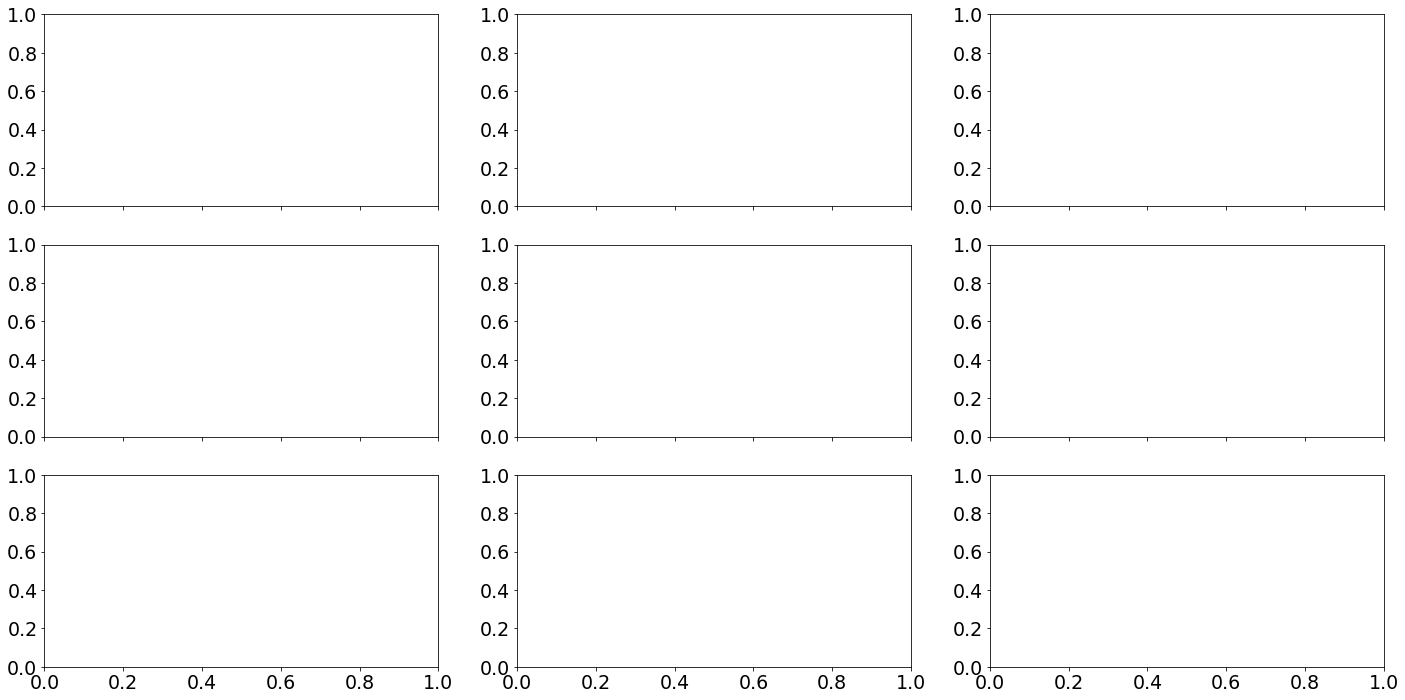

In [35]:
#Plots Figure 1
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker

mpl.rcParams.update({'font.size': 19})
proteins = ["OMPA", "ESTA", "OMPF"]
#lps_w = "RA"
eline=0.6
colours = ["r", "b", "g"]
names = ["OmpA", "EstA", "OmpF"]
plot_axes = []
lps_all = ["RE", "RA", "OANT"]
fig, axarray = plt.subplots(3, 3, figsize=(24, 12), sharex="col", sharey="col")
#print(axarray)
axarray = axarray.T
for prot, paxarray in zip(proteins, axarray):
    for lps_w, ax in zip(lps_all, paxarray):

        for lps in tilt_dict[prot]:
            if lps == lps_w or lps==lps_w +"_r":
                times = time_dict[prot][lps] / 1000.
                tilts = tilt_dict[prot][lps]
                times, tilts, errors = block_average(times, tilts, window=100)
                plot = ax.errorbar(times, tilts, yerr=errors, elinewidth=eline)
    

for i, name in enumerate(names):
    axarray[i, 0].set_title(names[i], fontsize=28)
    
size = 22
axarray[0, 2].set_ylabel(r'Tilt ( degrees )', fontsize=size)
axarray[0, 1].set_ylabel(r'Tilt ( degrees )', fontsize=size)
axarray[0, 0].set_ylabel(r'Tilt ( degrees )', fontsize=size)
axarray[0, -1].set_ylabel(r'Tilt ( degrees )', fontsize=size)
axarray[0, -1].set_xlabel(r'Time ( $\mu$s )', fontsize=size)
axarray[1, -1].set_xlabel(r'Time ( $\mu$s )', fontsize=size)
axarray[-1, -1].set_xlabel(r'Time ( $\mu$s )', fontsize=size)
axarray[1, 1].set_xlim(0, 30)
axarray[1, 1].set_ylim(0, 24)
axarray[0, 1].set_ylim(0, 26)
axarray[0, 1].yaxis.set_major_locator(ticker.MultipleLocator(5))
axarray[0, 1].set_xlim(0, 40)
axarray[2, 1].set_xlim(0, 30)
fig.tight_layout()
#fig.savefig("tilt_anglesp1.eps", dpi=300)

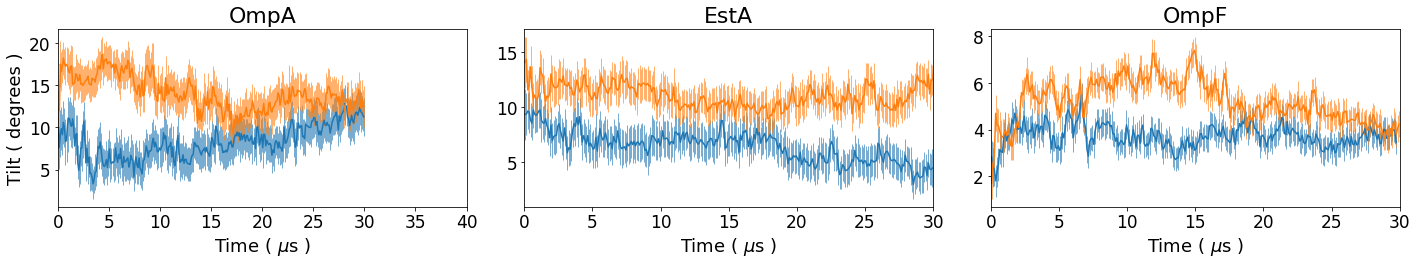

In [31]:
#Plots Figure S1B
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update({'font.size': 17})
proteins = ["OMPA", "ESTA", "OMPF"]
#lps_w = "RA"
eline=0.6
colours = ["r", "b", "g"]
names = ["OmpA", "EstA", "OmpF"]
plot_axes = []
lps_all = ["OANT_PE"]
fig, axarray = plt.subplots(1, 3, figsize=(20, 4), sharex="col")
axarray = axarray
for prot, ax in zip(proteins, axarray):
    lps_w = lps_all[0]

    for lps in tilt_dict[prot]:
        if lps == lps_w or lps==lps_w +"_r":
            times = time_dict[prot][lps] / 1000.
            tilts = tilt_dict[prot][lps]
            times, tilts, errors = block_average(times, tilts, window=100)
            plot = ax.errorbar(times, tilts, yerr=errors, elinewidth=eline)
    

for i, name in enumerate(names):
    axarray[i].set_title(names[i], fontsize=22)
    
size = 18
axarray[0].set_ylabel(r'Tilt ( degrees )', fontsize=size)
#axarray[-1].set_ylabel(r'Tilt ( degrees )', fontsize=size)
axarray[0].set_xlabel(r'Time ( $\mu$s )', fontsize=size)
axarray[1].set_xlabel(r'Time ( $\mu$s )', fontsize=size)
axarray[-1].set_xlabel(r'Time ( $\mu$s )', fontsize=size)
axarray[0].set_xlim(0, 40)
axarray[ 1].set_xlim(0, 30)
axarray[ 2].set_xlim(0, 30)
fig.tight_layout()
fig.savefig("tilt_anglesp1_oantpe.eps", dpi=300)

## Does each protein always tilt in the same direction?

In [12]:
point = np.array([1, 1, 5])
vector = np.array([0, 0, 1])
zero = np.zeros(3)

In [13]:
def residue_vector(protein_axis, res_cog, protein_com):
    normal = protein_axis / np.linalg.norm(protein_axis)
    v = res_cog - protein_com
    d = np.dot(v, normal)
    p_on_line = protein_com + normal * d
    vector = res_cog - p_on_line
    return vector    

In [14]:
residue_vector(vector, point, zero)

array([1., 1., 0.])

In [15]:
def calc_residue_tilt(barrel, structure, trajectory, cutoff=30, start=0, stop=-1, step=10, residue_sel=None):
    u = mda.Universe(structure, trajectory)
    if stop == -1:
        stop = u.trajectory.n_frames
    start, stop, step = u.trajectory.check_slice_indices(
        start, stop, step)
    
    num_steps = len(range(start, stop, step))
    if num_steps == 0:
        raise ValueError("Selected time interval does not exist in the trajectory")
    
    protein_trns_memb = u.atoms[barrel.indices]
    if residue_sel is not None:
        residue = u.select_atoms(residue_sel)
    z_axis = np.array([0., 0., 1.])
    z_axis_norm = np.linalg.norm(z_axis)
    tilt_angles = []
    time_series = []
    axes_tseries = []
    compare_axes = None
    for frame in u.trajectory[start:stop:step]:
        time_series.append(frame.time / 1000)
        axes = protein_trns_memb.principal_axes()
        
        axes_diff = [1 - abs(x) for x in axes[:, 2]]
        trans_membrane_axis_order = np.argmin(axes_diff)

        axes_tseries.append(trans_membrane_axis_order)
        if compare_axes is None:
            compare_axes = trans_membrane_axis_order
        else:
            if trans_membrane_axis_order != compare_axes:
                raise Exception("Error: transmembrane axes changes from {0} to {1} at time {2:d} ns".format(
                    compare_axes, trans_membrane_axis_order, int(frame.time / 1000.)))
        
        
        protein_axis = axes[trans_membrane_axis_order]
        if residue_sel is not None:
            res_cog = residue.atoms.center_of_geometry()
            protein_cog = protein_trns_memb.atoms.center_of_geometry()
            protein_axis = residue_vector(protein_axis, res_cog, protein_cog)
            
        
        tilt = np.arccos( np.dot(z_axis, protein_axis) / (z_axis_norm * np.linalg.norm(protein_axis) ) )
        tilt *= 0.5 * 360. / np.pi
        #if tilt > 90:
        #    tilt = 180 - tilt
        tilt_angles.append(tilt)
    tilt_angles = np.array(tilt_angles)
    time_series = np.array(time_series)
    return time_series, tilt_angles, np.array(axes_tseries)

In [16]:
relative_res = {"OMPA": "resid 144 and name BB", "ESTA":"resid 469 and name BB", "OMPF": "resid 232 and name BB" }
barrels = [barrelOMPA, barrelESTA, barrelOMPF]

In [19]:
wdir = "/media/jon/PhDparty/membrane_proteins/"
protein = ["OMPA","ESTA", "OMPF"] #names of protein directories

LPS_type = ["RE", "RA", "RA_r", "RE_r", "OANT", "OANT_r", "OANT_PE", "OANT_PE_r"] #names of membrane directories
#LPS_type = ["OANT_PE_r"]
time_dictr = {}
tilt_dictr = {}
axes_dictr = {} #stores info on the prinicpal axes used for each calculation for each frame
for i, p in enumerate(protein):
    for lps in LPS_type:
        membrane_protein = "{0}/{1}/".format(p, lps)
        path = wdir + membrane_protein

        try:

            time, tilt, axes = calc_residue_tilt(barrels[i], path + "production_whole.gro", 
                                                                   path+"production_whole.xtc", step=1, residue_sel=relative_res[p])
            print(p, lps)
            time_dictr[p][lps] = time
            tilt_dictr[p][lps] = tilt
            axes_dictr[p][lps] = axes
        except KeyError:
            time_dictr[p] = {}
            tilt_dictr[p] = {}
            axes_dictr[p] = {}
            time_dictr[p][lps] = time
            tilt_dictr[p][lps] = tilt
            axes_dictr[p][lps] = axes

OMPA RE
OMPA RA
OMPA RA_r
OMPA RE_r
OMPA OANT
OMPA OANT_r
OMPA OANT_PE
OMPA OANT_PE_r
ESTA RE
ESTA RA
ESTA RA_r
ESTA RE_r
ESTA OANT
ESTA OANT_r
ESTA OANT_PE
ESTA OANT_PE_r
OMPF RE
OMPF RA
OMPF RA_r
OMPF RE_r
OMPF OANT
OMPF OANT_r
OMPF OANT_PE
OMPF OANT_PE_r


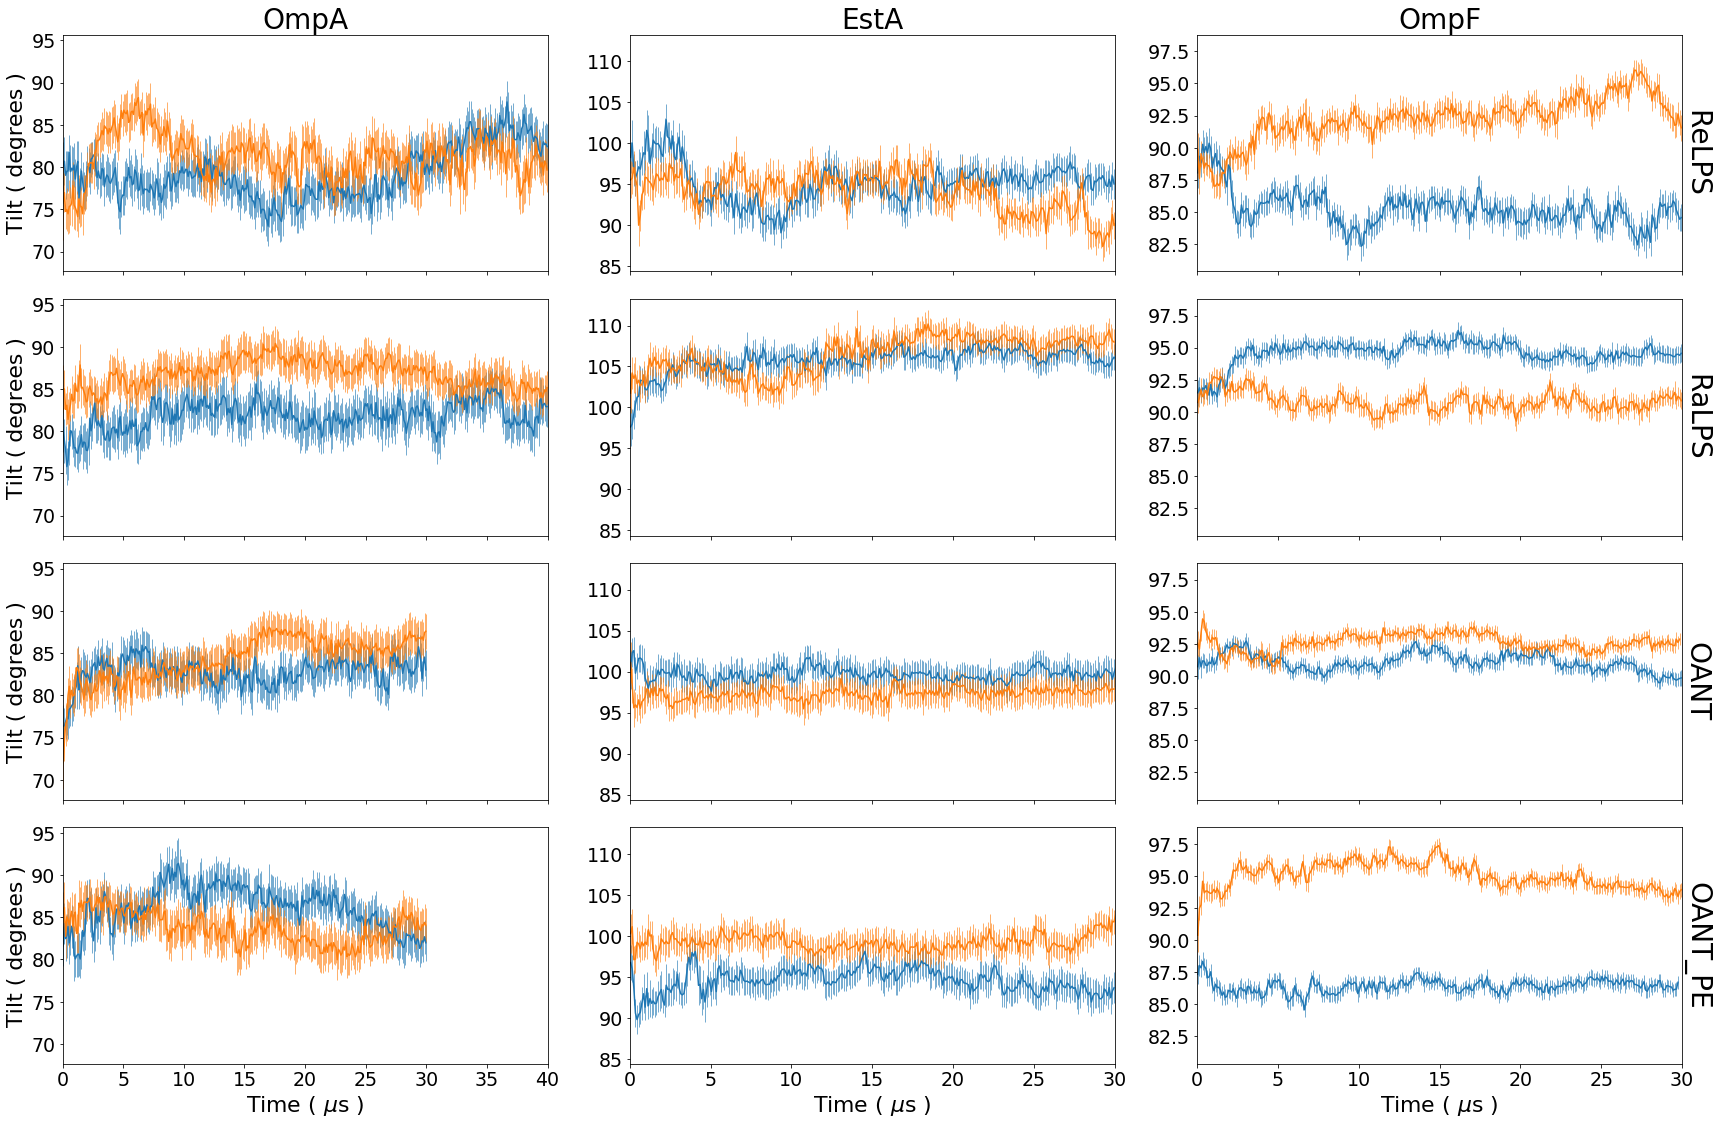

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker

mpl.rcParams.update({'font.size': 19})
proteins = ["OMPA", "ESTA", "OMPF"]
#lps_w = "RA"
eline=0.6
colours = ["r", "b", "g"]
names = ["OmpA", "EstA", "OmpF"]
plot_axes = []
lps_all = ["RE", "RA", "OANT", "OANT_PE"]
fig, axarray = plt.subplots(4, 3, figsize=(24, 16), sharex="col", sharey="col")
#print(axarray)
axarray = axarray.T
for prot, paxarray in zip(proteins, axarray):
    for lps_w, ax in zip(lps_all, paxarray):

        for lps in tilt_dictr[prot]:
            if lps == lps_w or lps==lps_w +"_r":
                times = time_dictr[prot][lps] / 1000.
                tilts = tilt_dictr[prot][lps]
                times, tilts, errors = block_average(times, tilts, window=100)
                plot = ax.errorbar(times, tilts, yerr=errors, elinewidth=eline)
    

for i, name in enumerate(names):
    axarray[i, 0].set_title(names[i], fontsize=28)

lps_names = [r"ReLPS", r"RaLPS", r"OANT", r"OANT_PE"]
for ax, name in zip(axarray[-1, :], lps_names):
    ax.text(1.0, 0.5, s=name, transform=ax.transAxes, verticalalignment='center', rotation=270, fontsize=28)
    
size = 22
axarray[0, 2].set_ylabel(r'Tilt ( degrees )', fontsize=size)
axarray[0, 1].set_ylabel(r'Tilt ( degrees )', fontsize=size)
axarray[0, 0].set_ylabel(r'Tilt ( degrees )', fontsize=size)
axarray[0, 3].set_ylabel(r'Tilt ( degrees )', fontsize=size)
axarray[0, 3].set_xlabel(r'Time ( $\mu$s )', fontsize=size)
axarray[1, 3].set_xlabel(r'Time ( $\mu$s )', fontsize=size)
axarray[-1, 3].set_xlabel(r'Time ( $\mu$s )', fontsize=size)
axarray[1, 1].set_xlim(0, 30)
axarray[0, 1].set_xlim(0, 40)
axarray[2, 1].set_xlim(0, 30)
axarray[2, 1].yaxis.set_major_locator(ticker.MultipleLocator(2.5))
fig.tight_layout()
fig.savefig('protein_tilt_direction.pdf')

In [34]:
path = "/media/jon/PhDparty/membrane_proteins/OMPA/RE_r/"
time, tilt, axes = calc_residue_tilt(barrels[0], path + "production_whole.gro", 
                                                                   path+"production_whole.xtc", step=100, residue_sel="resid 144 and name BB")

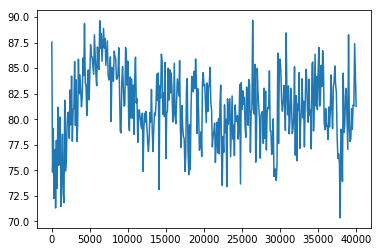

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(time, tilt)

In [38]:
path = "/media/jon/PhDparty/membrane_proteins/OMPA/RA_r/"
time, tilt, axes = calc_residue_tilt(barrels[0], path + "production_whole.gro", 
                                                                   path+"production_whole.xtc", step=100, residue_sel="resid 144 and name BB")

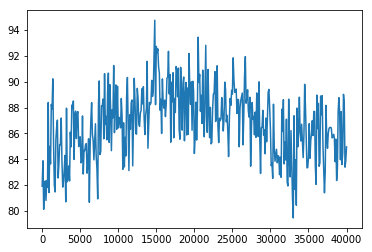

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(time, tilt)